# Import libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from operator import itemgetter
import networkx as nx
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
from math import sqrt
import statsmodels.formula.api as smf
from copy import deepcopy

# Import data

## Create network

In [2]:
G = nx.read_graphml('./london.graph.xml')

In [3]:
type(G)

networkx.classes.graph.Graph

In [4]:
# To check node attributes:
list(G.nodes(data = True))[0]

('Wembley Park', {'coords': '(519316.5590174915, 186389.32981656672)'})

In [5]:
#since coords tuples are stored as string, need to convert them back to tuples using eval()
for node in G.nodes():
    G.nodes[node]['coords'] = eval(G.nodes[node]['coords'])

In [6]:
# To check node attributes:
list(G.nodes(data = True))[0]

('Wembley Park', {'coords': (519316.5590174915, 186389.32981656672)})

In [7]:
# To check edges attributes:
list(G.edges(data = True))[0]

('Wembley Park',
 'Kingsbury',
 {'length': 2916.7715580506483, 'line_name': 'Jubilee', 'flows': 12356})

In [8]:
original_nodes = set(G.nodes())

isolated = list(nx.isolates(G))
G.remove_nodes_from(isolated)

updated_nodes = set(G.nodes())

removed_nodes = original_nodes - updated_nodes

print("Removed nodes:", removed_nodes)

Removed nodes: set()


In [9]:
extra_edges_removed = []

for u, v in list(G.edges()):
    if G.number_of_edges(u, v) > 1:
        extra_edges = list(G.edges(u, v))[1:]
        extra_edges_removed.extend(extra_edges)
        G.remove_edges_from(extra_edges) 

print("Removed extra edges:", extra_edges_removed)

Removed extra edges: []


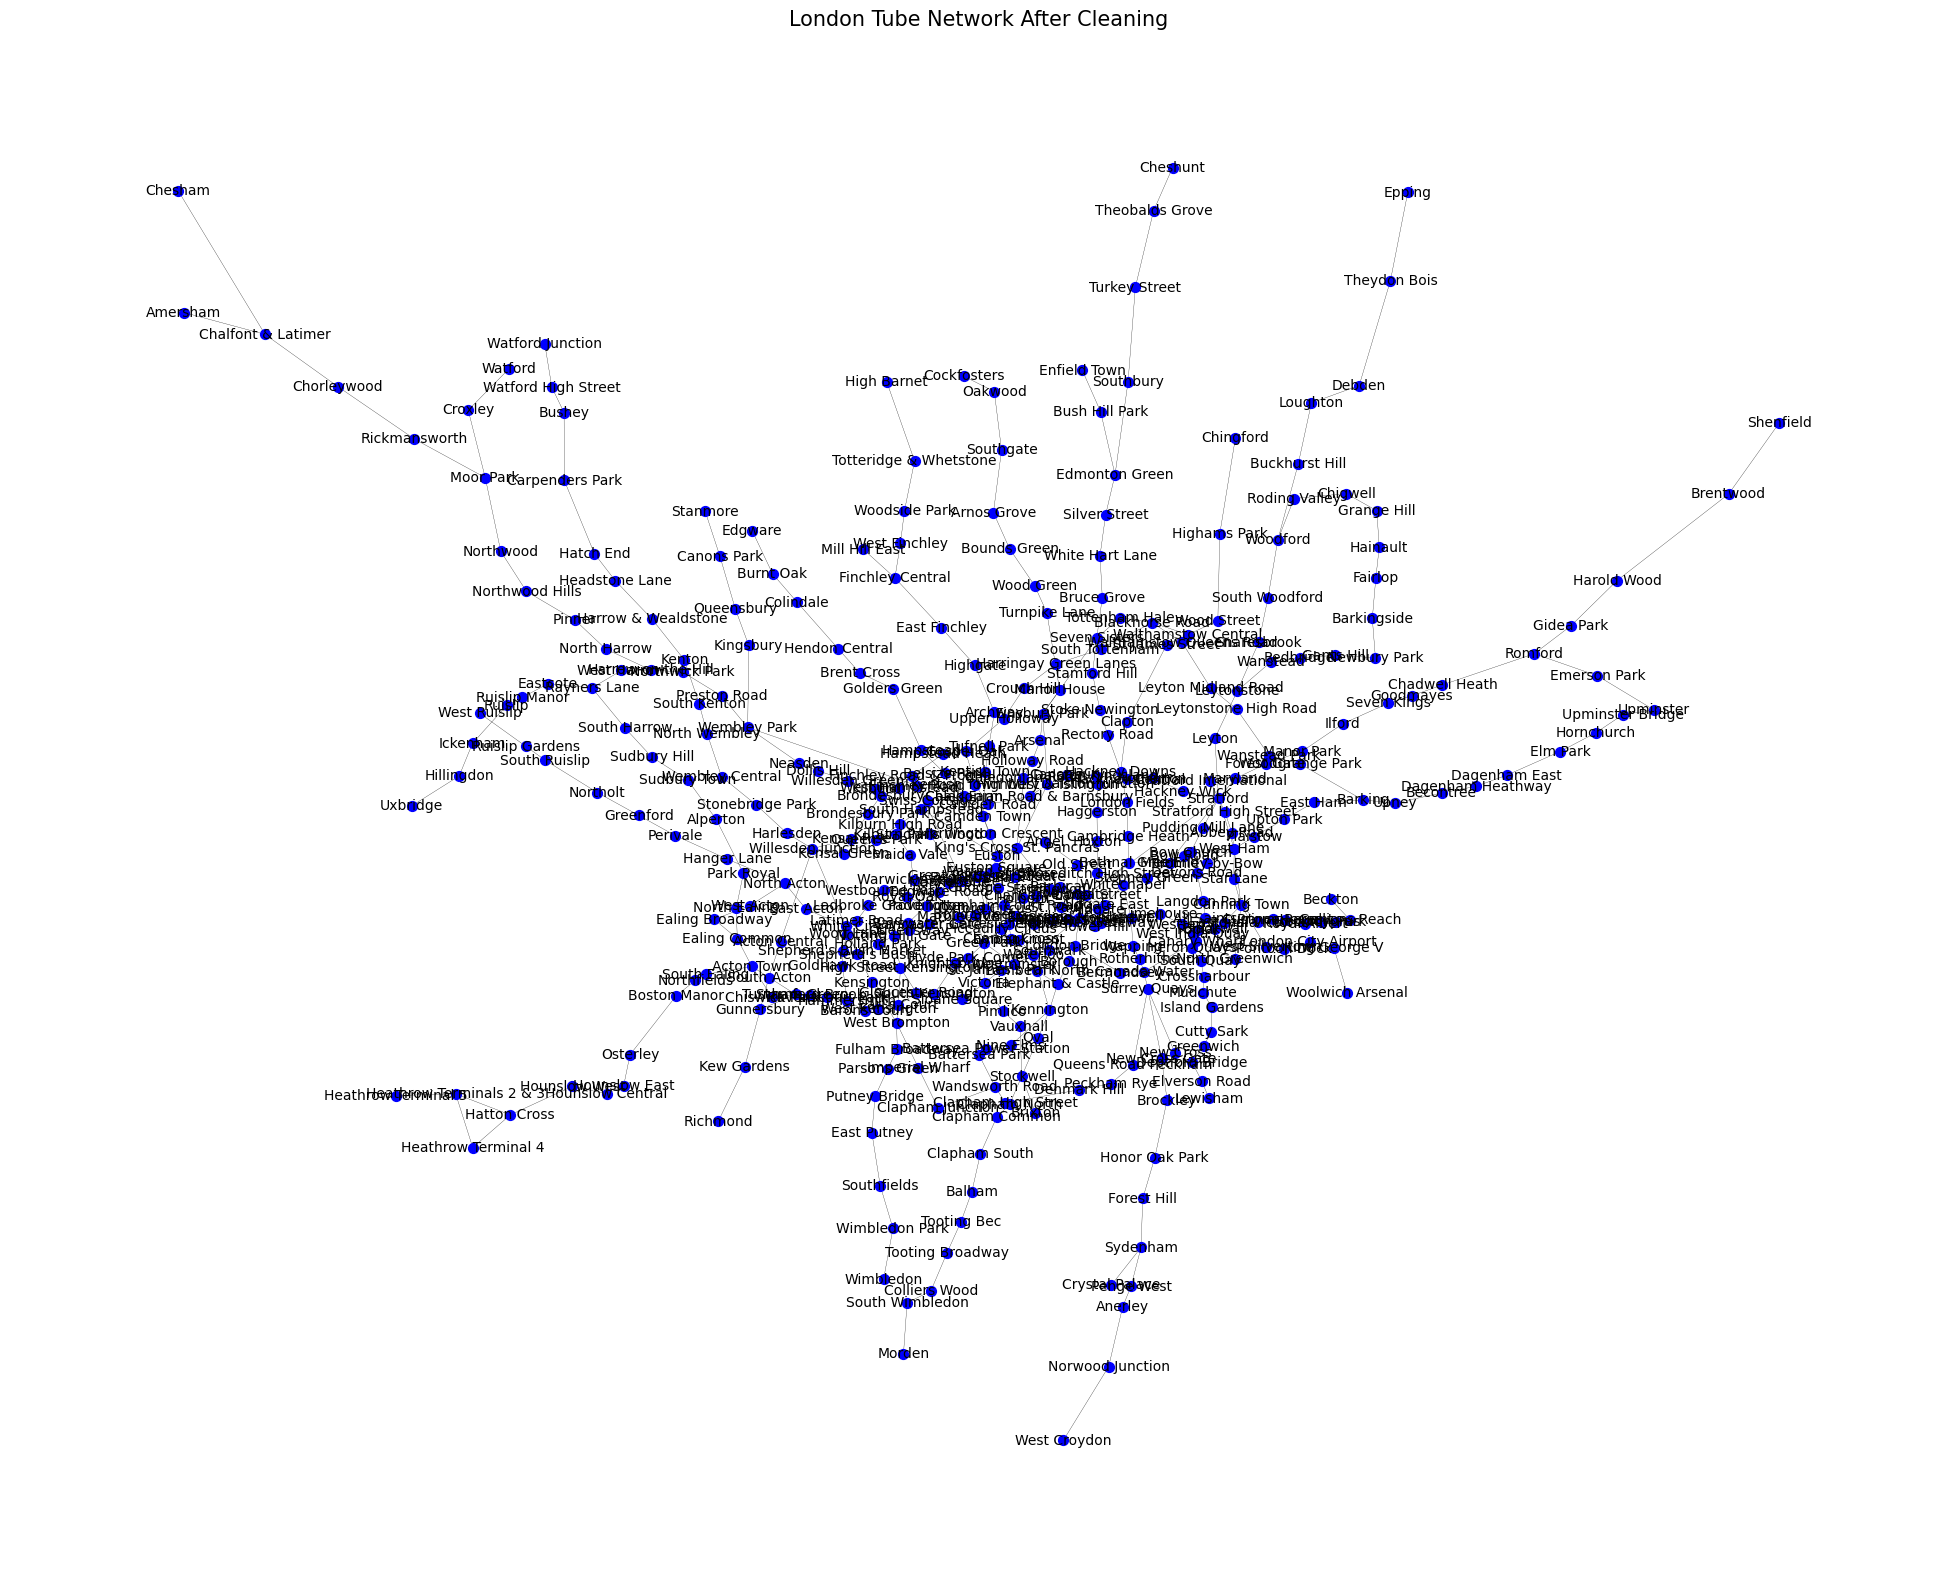

In [10]:
fig, ax = plt.subplots(figsize=(25,20))

node_labels = {node: node for node in G.nodes()} 

pos = nx.get_node_attributes(G, 'coords')

nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue')
nx.draw_networkx_edges(G, pos, arrows=False, width=0.2)
nx.draw_networkx_labels(G, pos, node_labels, font_size=10, font_color='black')

plt.title("London Tube Network After Cleaning", fontsize=15)
plt.axis("off")
plt.show()

In [11]:
# We can print the dataframe from the shapefile to check the data
df = nx.to_pandas_edgelist(G)
df

,source,target,line_name,length,flows
0,Wembley Park,Kingsbury,Jubilee,2916.771558,12356
1,Wembley Park,Neasden,Jubilee,2353.165938,6744
2,Wembley Park,Preston Road,Metropolitan,1419.735166,36601
3,Wembley Park,Finchley Road,Metropolitan,7266.373927,55216
4,Kingsbury,Queensbury,Jubilee,1245.995234,9419
...,...,...,...,...,...
462,Hounslow Central,Hounslow East,Piccadilly,745.684383,13469
463,Hounslow East,Osterley,Piccadilly,967.494672,15935
464,Osterley,Boston Manor,Piccadilly,2560.814291,17445
465,Boston Manor,Northfields,Piccadilly,930.852145,18598


In [12]:
# 设置起始站名称，假设为'StationA'
start_station = 'Ealing Broadway'

# 筛选出所有起始站为'StationA'的行
filtered_df = df[df['source'] == start_station]

# 查看筛选结果
print(filtered_df)

             source         target line_name       length  flows
71  Ealing Broadway  Ealing Common  District  1565.297083  10022


## Import csv

In [13]:
df_od = pd.read_csv('london_flows.csv')

df_od.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [14]:
df_od.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61474 entries, 0 to 61473
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61474 non-null  object 
 1   station_destination  61474 non-null  object 
 2   flows                61474 non-null  int64  
 3   population           61474 non-null  int64  
 4   jobs                 61474 non-null  int64  
 5   distance             61474 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 2.8+ MB


In [15]:
missing_colum = df_od.isnull().sum()
print("Missing values per column:")
print(missing_colum)

total_missing = missing_colum.sum()
print("Total missing values in the dataset:", total_missing)

if total_missing > 0:
    print("Rows with missing values:")
    print(df_od[df_od.isnull().any(axis=1)])

Missing values per column:
station_origin         0
station_destination    0
flows                  0
population             0
jobs                   0
distance               0
dtype: int64
Total missing values in the dataset: 0


In [16]:
G_w = G.copy()

In [17]:
line_names = set()
for u, v, data in G_w.edges(data=True):
    if 'line_name' in data:
        line_names.add(data['line_name'])

line_names = sorted(line_names, key=str.lower)

print(line_names)

['Bakerloo', 'Central', 'Circle', 'District', 'DLR', 'Hammersmith & City', 'Jubilee', 'London Overground', 'Metropolitan', 'Northern', 'Piccadilly', 'TfL Rail', 'Victoria', 'Waterloo & City']


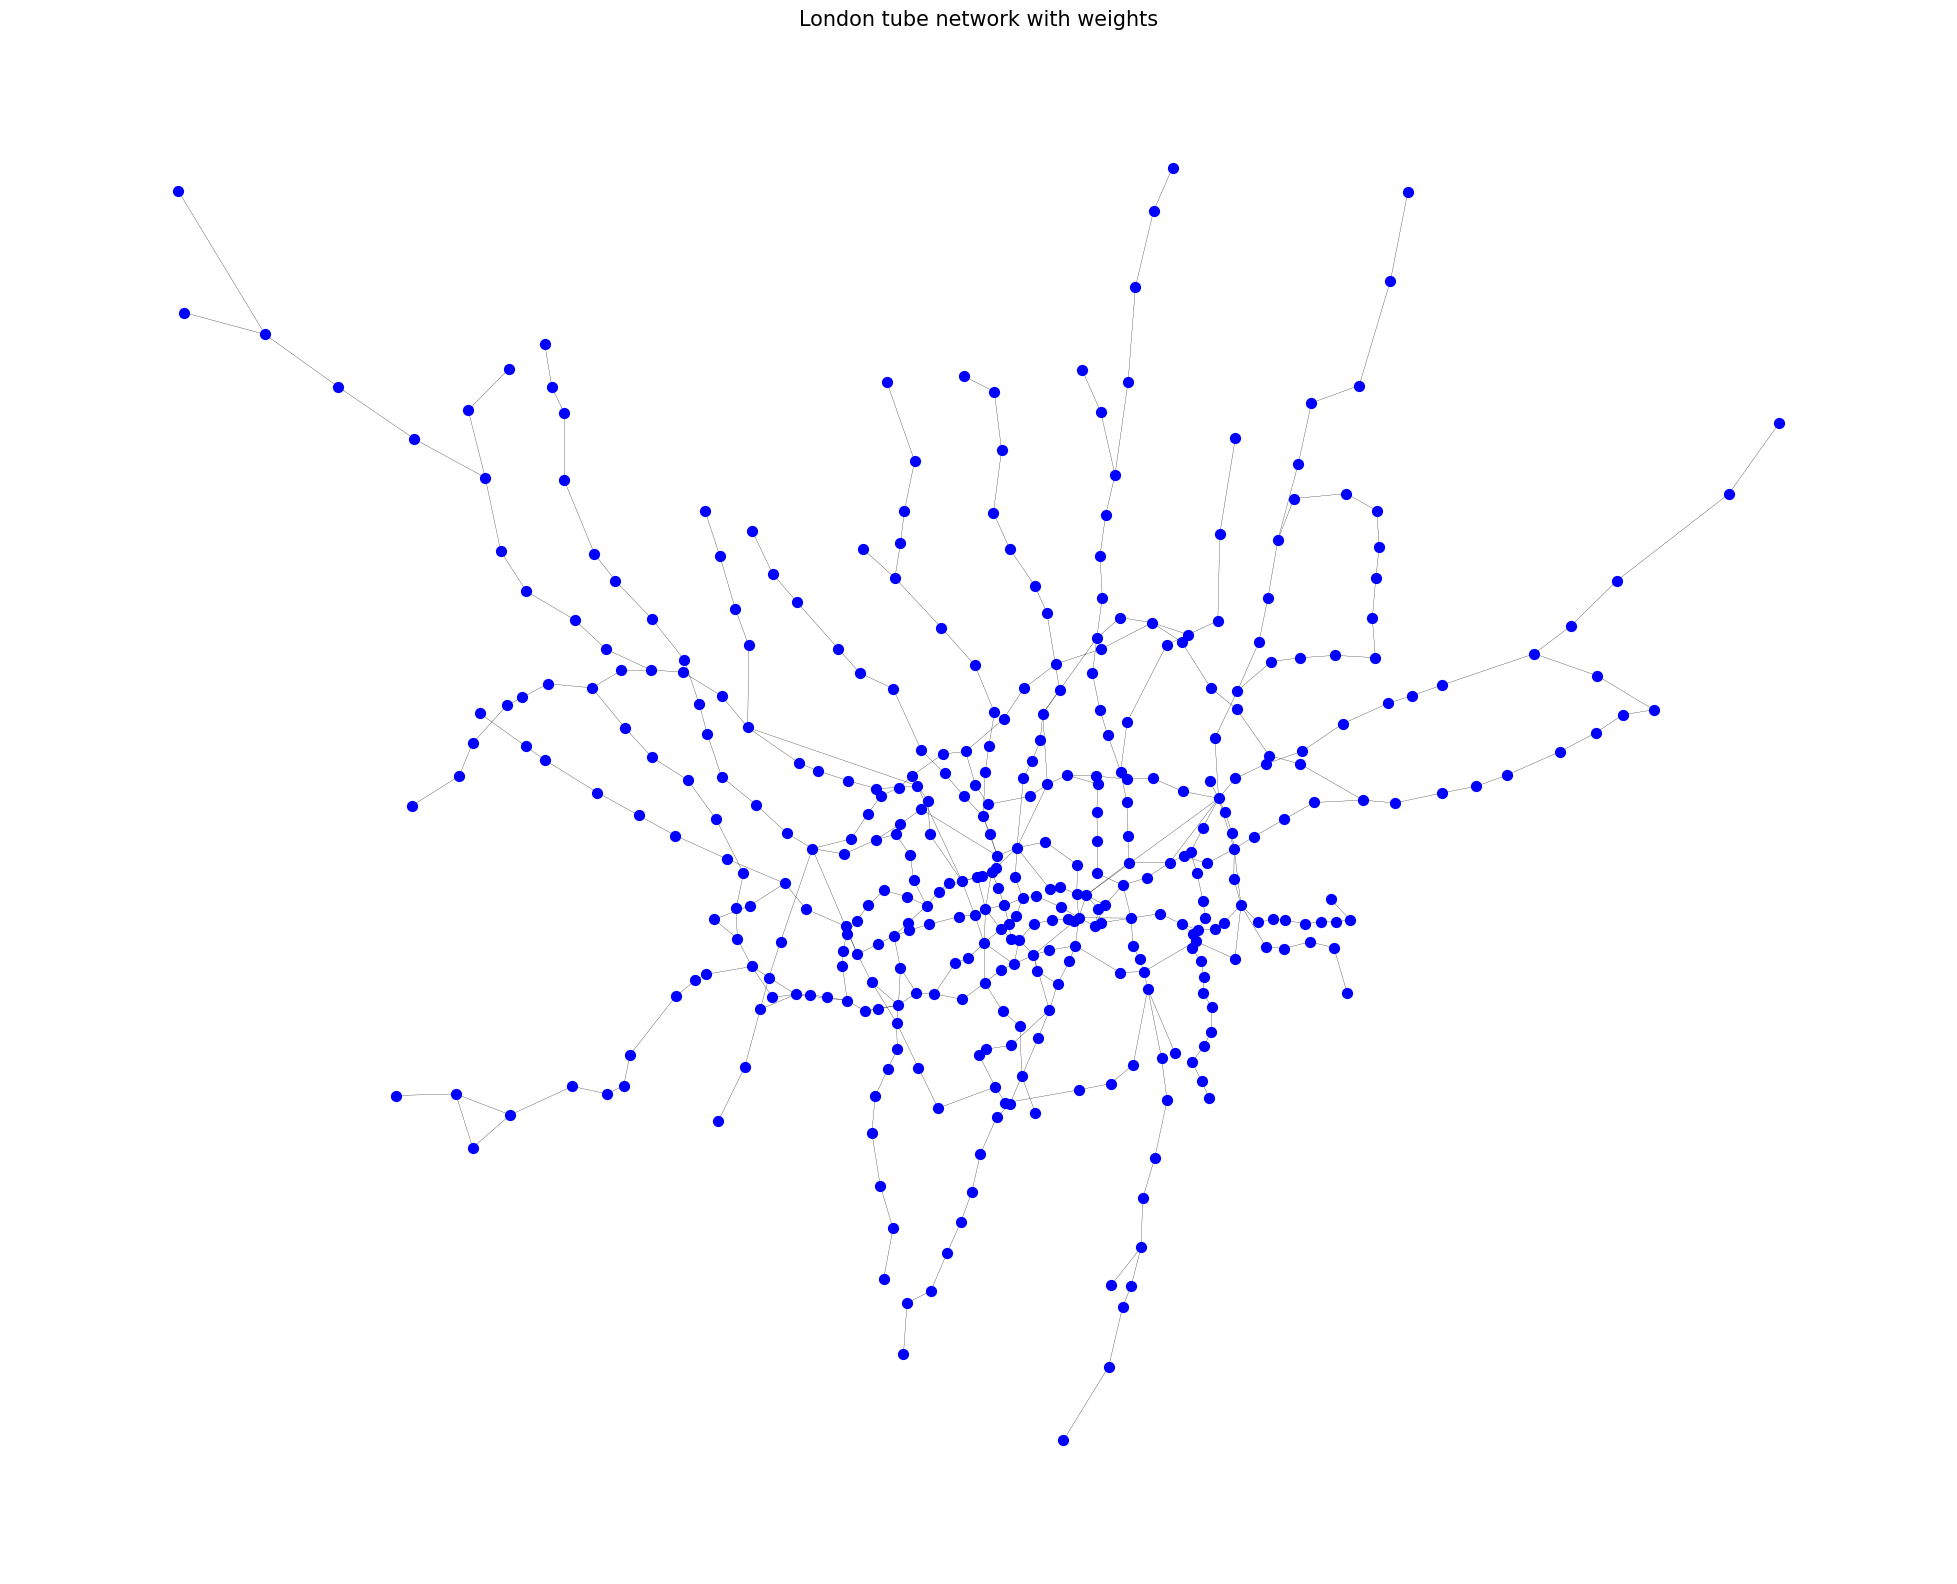

In [18]:
fig, ax = plt.subplots(figsize=(25,20))

node_labels = {node: node for node in G_w.nodes()} 

pos = nx.get_node_attributes(G_w, 'coords') 

nx.draw_networkx_nodes(G_w, pos, node_size=50, node_color='b')
nx.draw_networkx_edges(G_w, pos, arrows=False, width=0.2)

plt.title("London tube network with weights", fontsize=15)
plt.axis("off")
plt.show()

## Merge

In [19]:
df_od_w = df_od.copy()

In [20]:
od_names = set(df_od_w.station_origin.unique())
network_names = set([n for n in G_w.nodes()])

In [21]:
network_names.symmetric_difference(od_names)

{'Battersea Power Station', 'Nine Elms'}

In [22]:
missing_in_network = [name for name in ['Battersea Power Station', 'Nine Elms'] if name not in network_names]
if missing_in_network:
    print("The following stations do not exist in the network data:", missing_in_network)
else:
    print("All listed stations exist in the network data.")

All listed stations exist in the network data.


In [23]:
missing_in_od = [name for name in ['Battersea Power Station', 'Nine Elms'] if name not in od_names]
if missing_in_od:
    print("The following stations do not exist in the flows data:", missing_in_od)
else:
    print("All listed stations exist in the flows data.")

The following stations do not exist in the flows data: ['Battersea Power Station', 'Nine Elms']


In [24]:
node_list = set(G_w.nodes())
no_data_nodes = node_list.difference(set(df_od_w['station_origin'].unique()).union(set(df_od_w['station_destination'].unique())))
print(no_data_nodes)

{'Nine Elms', 'Battersea Power Station'}


In [25]:
pseudo_flows = pd.DataFrame({
    'station_origin': list(node_list),
    'station_destination': list(node_list),
    'flows': [0.001] * len(node_list) 
})
df_od_w = pd.concat([df_od_w, pseudo_flows], ignore_index=True)

In [26]:
df_od_w['flows_w'] = df_od_w ['flows'].replace(0, 0.001)

In [27]:
stations_to_check = ['Nine Elms', 'Battersea Power Station']

results = df_od_w[(df_od_w['station_origin'].isin(stations_to_check)) |
                  (df_od_w['station_destination'].isin(stations_to_check))]

results

,station_origin,station_destination,flows,population,jobs,distance,flows_w
61509,Battersea Power Station,Battersea Power Station,0.001,NaN,NaN,NaN,0.001
61870,Nine Elms,Nine Elms,0.001,NaN,NaN,NaN,0.001


In [28]:
df_od_w.head(10)

,station_origin,station_destination,flows,population,jobs,distance,flows_w
0,Abbey Road,Bank and Monument,0.0,599.0,78549.0,8131.525097,0.001
1,Abbey Road,Beckton,1.0,599.0,442.0,8510.121774,1.000
2,Abbey Road,Blackwall,3.0,599.0,665.0,3775.448872,3.000
3,Abbey Road,Canary Wharf,1.0,599.0,58772.0,5086.514220,1.000
4,Abbey Road,Canning Town,37.0,599.0,15428.0,2228.923167,37.000
5,Abbey Road,Crossharbour,1.0,599.0,1208.0,6686.475560,1.000
6,Abbey Road,Custom House,0.0,599.0,845.0,3824.855630,0.001
7,Abbey Road,Cutty Sark,2.0,599.0,1748.0,8503.898909,2.000
8,Abbey Road,Cyprus,7.0,599.0,850.0,6532.099618,7.000
9,Abbey Road,Devons Road,1.0,599.0,611.0,3958.324171,1.000


## Flows: weighted network

In [29]:
#create a dictionary to store flows for all edges
flows_w = {(u,v): 0 for u,v in G_w.edges()}

In [30]:
for i, row in df_od_w.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G_w, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            flows_w[(u,v)] += row.flows_w
        except:
            flows_w[(v,u)] += row.flows_w

In [31]:
nx.set_edge_attributes(G_w, flows_w, 'flows_w')

In [32]:
# 检查是否还存在为零的流量值
zero_flows = any(d['flows_w'] == 0 for _, _, d in G_w.edges(data=True))
if zero_flows:
    print("have 0.")
else:
    print("no 0.")

have 0.


In [33]:
for u, v, d in G_w.edges(data=True):
    if d['flows_w'] == 0:
        print(f"Edge ({u}, {v}) has zero flow.")
        G_w[u][v]['flows_w'] = 0.001

Edge (Kennington, Nine Elms) has zero flow.
Edge (Battersea Power Station, Nine Elms) has zero flow.


In [34]:
zero_flows = any(d['flows_w'] == 0 for _, _, d in G_w.edges(data=True))
if zero_flows:
    print("have 0.")
else:
    print("no 0.")

no 0.


In [35]:
u, v = list(G_w.edges())[0] 
print("Edge:", u, v, "flows_w:", G_w[u][v]['flows_w'])

Edge: Wembley Park Kingsbury flows_w: 12356.546000000093


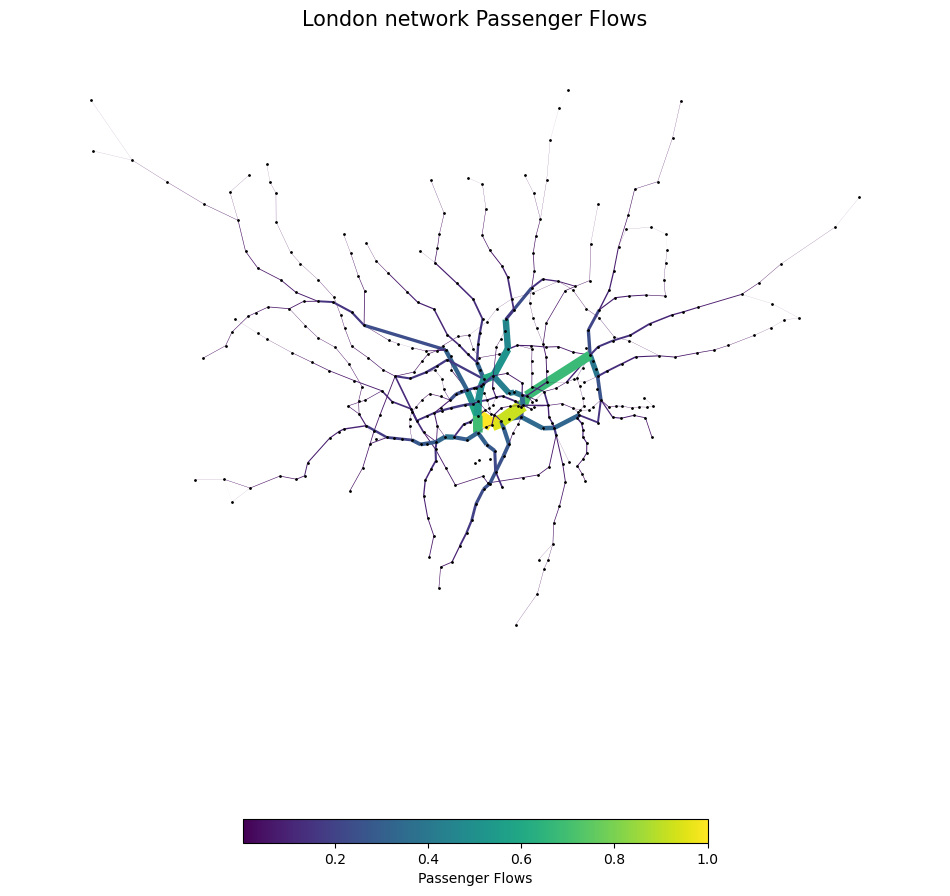

In [36]:
flows_values = flows_w.values()
flow_color = [(i[2]['flows_w']/max(flows_values)) for i in G_w.edges(data=True)]
flow_width = [(i[2]['flows_w']/max(flows_values)*10) for i in G_w.edges(data=True)]

fig, ax = plt.subplots(figsize=(12,12))

edg = nx.draw_networkx_edges(G_w, pos, edge_color=flow_color, width=flow_width)

nx.draw_networkx_nodes(G_w,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Flows",fontsize=15)
plt.show()

# Weighted centrality measures

## Deg_w

In [91]:
deg_london = nx.degree_centrality(G_w)
nx.set_node_attributes(G_w, dict(deg_london), 'degree_w')

In [92]:
# To dataframe using the nodes as the index
df_deg = pd.DataFrame(index=G_w.nodes())
df_deg['degree_w'] = pd.Series(nx.get_node_attributes(G_w, 'degree_w'))

pd.options.display.float_format = '{:.6f}'.format

df_deg_updated_initial = df_deg.sort_values(["degree_w"], ascending=False)
df_deg_updated_initial.head(10)

,degree_w
Stratford,0.022500
Bank and Monument,0.020000
King's Cross St. Pancras,0.017500
Baker Street,0.017500
Earl's Court,0.015000
Oxford Circus,0.015000
Liverpool Street,0.015000
Waterloo,0.015000
Green Park,0.015000
Canning Town,0.015000


## Clo_w

In [39]:
for u, v, d in G_w.edges(data=True):
    # 计算流量的倒数，并将其存储在新的边属性 'inverse_flow' 中
    d['inverse_flow'] = 1.0 / d['flows_w'] if d['flows_w'] != 0 else 0

In [40]:
clos_w=nx.closeness_centrality(G_w, distance='inverse_flow')
# We can add these values to the nodes attributes:
nx.set_node_attributes(G_w,clos_w,'closeness_w')

# To ataframe using the nodes as the index
df_clo_w = pd.DataFrame(index=G_w.nodes())
df_clo_w ['closeness_w'] = pd.Series(nx.get_node_attributes(G_w, 'closeness_w'))

df_clo_w_sorted = df_clo_w.sort_values(["closeness_w"], ascending=False)
pd.set_option('display.float_format', '{:.8f}'.format)
df_clo_w_sorted[0:10]

,closeness_w
Green Park,0.13230036
Westminster,0.13230035
Waterloo,0.13230033
Bank and Monument,0.13230031
Oxford Circus,0.13230029
Victoria,0.13230029
Bond Street,0.13230028
Liverpool Street,0.13230025
Warren Street,0.13230022
Stratford,0.13230018


## Bet_w

In [41]:
for u, v, d in G_w.edges(data=True):
    # 计算流量的倒数，并将其存储在新的边属性 'inverse_flow' 中
    d['inverse_flow'] = 1.0 / d['flows_w'] if d['flows_w'] != 0 else 0

In [42]:
bet_w = nx.betweenness_centrality(G_w, weight='inverse_flow', normalized=False)

nx.set_node_attributes(G_w, bet_w, 'betweenness_w')

df_bet_w = pd.DataFrame(list(bet_w.items()), columns=['Node', 'betweenness_w'])

df_bet_w_sorted = df_bet_w.sort_values(by='betweenness_w', ascending=False)

df_bet_w_sorted.head(10)

,Node,betweenness_w
16,Green Park,44845.00000000
50,Bank and Monument,40381.00000000
14,Waterloo,32610.00000000
15,Westminster,30568.00000000
51,Liverpool Street,27278.00000000
5,Stratford,26963.00000000
150,Euston,22657.00000000
17,Bond Street,22281.00000000
45,Oxford Circus,20908.00000000
18,Baker Street,19297.00000000


# Weighted Impact Measures

### WM

In [43]:
import community  # 使用python-louvain库

# 使用Louvain方法进行社区检测
partition = community.best_partition(G_w, weight='flows_w')
modularity = community.modularity(partition, G_w, weight='flows_w')
print("The modularity of the detected community structure is:", modularity)

The modularity of the detected community structure is: 0.7344948959143767


### PFL

In [44]:
def calculate_total_flow(G):
    total_flow = sum(data['flows_w'] for u, v, data in G.edges(data=True))
    return total_flow

total_flow_original = calculate_total_flow(G_w)
print("Total flow in the original network:", total_flow_original)

Total flow in the original network: 9931082.630999919


# Node removal

## Best centrality fromⅠ

top 3 from bet：Stratford，Bank and Monument，Liverpool Street

### 1

In [45]:
import community as community_louvain

In [46]:
G_w_1 = deepcopy(G_w)

G_w_1.remove_node('Stratford')

def calculate_modularity(G):
    # 使用 community 库来找到网络的最佳社区划分
    partition = community_louvain.best_partition(G, weight='flows_w')
    # 计算并返回模块化
    modularity = community_louvain.modularity(partition, G, weight='flows_w')
    return modularity

# 计算修改后网络的模块化
network_modularity = calculate_modularity(G_w_1)
print("Modified network modularity:", network_modularity)

Modified network modularity: 0.7460019746944261


In [47]:
for u, v, d in G_w_1.edges(data=True):
    d['weight'] = d['flows_w']
    
def calculate_total_flow(G):
    total_flow = sum(data['flows_w'] for u, v, data in G.edges(data=True))
    return total_flow

total_flow_original = calculate_total_flow(G_w) 
print("Total flow in the original network:", total_flow_original)

total_flow_remaining = calculate_total_flow(G_w_1)
print("Remaining flow in the network after node removal:", total_flow_remaining)

flow_loss = total_flow_original - total_flow_remaining
print("Flow loss due to node removal:", flow_loss)

Total flow in the original network: 9931082.630999919
Remaining flow in the network after node removal: 9542972.43399993
Flow loss due to node removal: 388110.19699998945


### 2

In [48]:
G_w_1.remove_node('Bank and Monument')

def calculate_modularity(G):
    # 使用 community 库来找到网络的最佳社区划分
    partition = community_louvain.best_partition(G, weight='flows_w')
    # 计算并返回模块化
    modularity = community_louvain.modularity(partition, G, weight='flows_w')
    return modularity

# 计算修改后网络的模块化
network_modularity = calculate_modularity(G_w_1)
print("Removal Bank and Monument network modularity:", network_modularity)

Removal Bank and Monument network modularity: 0.7711996097385163


In [49]:
for u, v, d in G_w_1.edges(data=True):
    d['weight'] = d['flows_w'] 

def calculate_total_flow(G):
    total_flow = sum(data['flows_w'] for u, v, data in G.edges(data=True))
    return total_flow

total_flow_original = calculate_total_flow(G_w)
print("Total flow in the original network:", total_flow_original)

total_flow_remaining = calculate_total_flow(G_w_1)
print("Remaining flow in the network after removing 'Bank and Monument':", total_flow_remaining)

flow_loss = total_flow_original - total_flow_remaining
print("Flow loss due to removing 'Bank and Monument':", flow_loss)

Total flow in the original network: 9931082.630999919
Remaining flow in the network after removing 'Bank and Monument': 8928689.28999994
Flow loss due to removing 'Bank and Monument': 1002393.3409999795


### 3

In [50]:
G_w_1.remove_node('Liverpool Street')

def calculate_modularity(G):
    # 使用 community 库来找到网络的最佳社区划分
    partition = community_louvain.best_partition(G, weight='flows_w')
    # 计算并返回模块化
    modularity = community_louvain.modularity(partition, G, weight='flows_w')
    return modularity

# 计算修改后网络的模块化
network_modularity = calculate_modularity(G_w_1)
print("Removal Liverpool Street network modularity:", network_modularity)

Removal Liverpool Street network modularity: 0.7749999386075852


In [51]:
for u, v, d in G_w_1.edges(data=True):
    d['weight'] = d['flows_w'] 
    
def calculate_total_flow(G):
    total_flow = sum(data['flows_w'] for u, v, data in G.edges(data=True))
    return total_flow

total_flow_original = calculate_total_flow(G_w)
print("Total flow in the original network:", total_flow_original)

total_flow_remaining = calculate_total_flow(G_w_1)
print("Remaining flow in the network after removing 'Liverpool Street':", total_flow_remaining)

flow_loss = total_flow_original - total_flow_remaining
print("Flow loss due to removing 'Liverpool Street':", flow_loss)

Total flow in the original network: 9931082.630999919
Remaining flow in the network after removing 'Liverpool Street': 8842894.74899994
Flow loss due to removing 'Liverpool Street': 1088187.8819999788


## Strategy B

### B - deg_w

In [52]:
G_w_deg_b = deepcopy(G_w)

#### 1

In [53]:
G_w_deg_b.remove_node('Stratford')

In [54]:
def calculate_modularity(G):
    # 使用 community 库来找到网络的最佳社区划分
    partition = community_louvain.best_partition(G, weight='flows_w')
    # 计算并返回模块化
    modularity = community_louvain.modularity(partition, G, weight='flows_w')
    return modularity

# 计算修改后网络的模块化
modularity_after_removal = calculate_modularity(G_w_deg_b)
print("Modified network modularity after removing 'Stratford':", modularity_after_removal)

def calculate_total_flow(G):
    total_flow = sum(data['flows_w'] for _, _, data in G.edges(data=True) if 'flows_w' in data)
    return total_flow

total_flow_original = calculate_total_flow(G_w)
total_flow_remaining = calculate_total_flow(G_w_deg_b)

flow_loss = total_flow_original - total_flow_remaining

print("Flow loss due to removing 'Stratford':", flow_loss)

Modified network modularity after removing 'Stratford': 0.7520617204410938
Flow loss due to removing 'Stratford': 388110.19699998945


In [55]:
deg_london_b = nx.degree_centrality(G_w_deg_b)
nx.set_node_attributes(G_w_deg_b, dict(deg_london_b), 'degree_w')

# 将节点和它们的度中心性存入 DataFrame
df_deg_b = pd.DataFrame(index=G_w_deg_b.nodes())
df_deg_b['degree_w'] = pd.Series(nx.get_node_attributes(G_w_deg_b, 'degree_w'))

# 按度中心性值降序排序
df_deg_sorted_b = df_deg_b.sort_values(by="degree_w", ascending=False)

# 找到度中心性排名第一的节点
top_node = df_deg_sorted_b.iloc[0]
print("Node with the highest degree centrality in G_w_deg_b:", top_node.name, "with centrality:", top_node['degree_w'])

Node with the highest degree centrality in G_w_deg_b: Bank and Monument with centrality: 0.020050125313283207


#### 2

In [56]:
G_w_deg_b.remove_node('Bank and Monument')

In [57]:
def calculate_modularity(G):
    # 使用 community 库来找到网络的最佳社区划分
    partition = community_louvain.best_partition(G, weight='flows_w')
    # 计算并返回模块化
    modularity = community_louvain.modularity(partition, G, weight='flows_w')
    return modularity

# 计算修改后网络的模块化
modularity_after_removal = calculate_modularity(G_w_deg_b)
print("Modified network modularity after removing 'Bank and Monument':", modularity_after_removal)

def calculate_total_flow(G):
    total_flow = sum(data['flows_w'] for _, _, data in G.edges(data=True) if 'flows_w' in data)
    return total_flow

total_flow_original = calculate_total_flow(G_w)
total_flow_remaining = calculate_total_flow(G_w_deg_b)

flow_loss = total_flow_original - total_flow_remaining

print("Flow loss due to removing 'Bank and Monument':", flow_loss)

Modified network modularity after removing 'Bank and Monument': 0.7720559362096125
Flow loss due to removing 'Bank and Monument': 1002393.3409999795


In [58]:
deg_london_b = nx.degree_centrality(G_w_deg_b)
nx.set_node_attributes(G_w_deg_b, dict(deg_london_b), 'degree_w')

# 将节点和它们的度中心性存入 DataFrame
df_deg_b = pd.DataFrame(index=G_w_deg_b.nodes())
df_deg_b['degree_w'] = pd.Series(nx.get_node_attributes(G_w_deg_b, 'degree_w'))

# 按度中心性值降序排序
df_deg_sorted_b = df_deg_b.sort_values(by="degree_w", ascending=False)

# 找到度中心性排名第一的节点
top_node = df_deg_sorted_b.iloc[0]
print("Node with the highest degree centrality in G_w_deg_b:", top_node.name, "with centrality:", top_node['degree_w'])

Node with the highest degree centrality in G_w_deg_b: Baker Street with centrality: 0.017587939698492462


#### 3

In [59]:
G_w_deg_b.remove_node("Baker Street")

In [60]:
def calculate_modularity(G):
    # 使用 community 库来找到网络的最佳社区划分
    partition = community_louvain.best_partition(G, weight='flows_w')
    # 计算并返回模块化
    modularity = community_louvain.modularity(partition, G, weight='flows_w')
    return modularity

# 计算修改后网络的模块化
modularity_after_removal = calculate_modularity(G_w_deg_b)
print("Modified network modularity after removing 'Baker Street':", modularity_after_removal)

def calculate_total_flow(G):
    total_flow = sum(data['flows_w'] for _, _, data in G.edges(data=True) if 'flows_w' in data)
    return total_flow

total_flow_original = calculate_total_flow(G_w)
total_flow_remaining = calculate_total_flow(G_w_deg_b)

flow_loss = total_flow_original - total_flow_remaining

print("Flow loss due to removing 'Baker Street':", flow_loss)

Modified network modularity after removing 'Baker Street': 0.7879951085059896
Flow loss due to removing 'Baker Street': 1309933.2519999836


### B - clo_w

In [61]:
G_w_clo_b = deepcopy(G_w)

#### 1

In [62]:
G_w_clo_b.remove_node('Green Park')

In [63]:
def calculate_modularity(G):
    # 使用 community 库来找到网络的最佳社区划分，确保使用 'flows_w' 作为权重
    partition = community_louvain.best_partition(G, weight='flows_w')
    # 计算并返回模块化
    modularity = community_louvain.modularity(partition, G, weight='flows_w')
    return modularity

# 确保使用适当的网络变量
modularity_after_removal = calculate_modularity(G_w_clo_b)
print("Modified network modularity after removing 'Green Park':", modularity_after_removal)

def calculate_total_flow(G):
    # 直接使用 'flows_w' 计算总流量，不重新定义权重
    total_flow = sum(data['flows_w'] for _, _, data in G.edges(data=True) if 'flows_w' in data)
    return total_flow

# 计算原始和修改后的网络的总流量
total_flow_original = calculate_total_flow(G_w)
total_flow_remaining = calculate_total_flow(G_w_clo_b)

# 计算流量损失
flow_loss = total_flow_original - total_flow_remaining
print("Flow loss due to removing 'Green Park':", flow_loss)

Modified network modularity after removing 'Green Park': 0.7730301179216987
Flow loss due to removing 'Green Park': 719871.3739999924


In [64]:
for u, v, d in G_w_clo_b.edges(data=True):
    d['inverse_flow'] = 1.0 / d['flows_w'] if d['flows_w'] != 0 else 0

In [65]:
# Recalculate the weighted closeness centrality in G_w_clo_b
clos_w = nx.closeness_centrality(G_w_clo_b, distance='inverse_flow')
nx.set_node_attributes(G_w_clo_b, clos_w, 'closeness_w')

# Convert to DataFrame using the nodes as the index
df_clo_w = pd.DataFrame(index=G_w_clo_b.nodes())
df_clo_w['closeness_w'] = pd.Series(nx.get_node_attributes(G_w_clo_b, 'closeness_w'))

df_clo_w_sorted = df_clo_w.sort_values(["closeness_w"], ascending=False)
pd.set_option('display.float_format', '{:.8f}'.format)
top_node = df_clo_w_sorted.head(1)
print(top_node)

                   closeness_w
Bank and Monument   0.13196908


#### 2

In [66]:
G_w_clo_b.remove_node('Bank and Monument')

In [67]:
def calculate_modularity(G):
    # 使用 community 库来找到网络的最佳社区划分，确保使用 'flows_w' 作为权重
    partition = community_louvain.best_partition(G, weight='flows_w')
    # 计算并返回模块化
    modularity = community_louvain.modularity(partition, G, weight='flows_w')
    return modularity

# 确保使用适当的网络变量
modularity_after_removal = calculate_modularity(G_w_clo_b)
print("Modified network modularity after removing 'Bank and Monument':", modularity_after_removal)

def calculate_total_flow(G):
    # 直接使用 'flows_w' 计算总流量，不重新定义权重
    total_flow = sum(data['flows_w'] for _, _, data in G.edges(data=True) if 'flows_w' in data)
    return total_flow

# 计算原始和修改后的网络的总流量
total_flow_original = calculate_total_flow(G_w)
total_flow_remaining = calculate_total_flow(G_w_clo_b)

# 计算流量损失
flow_loss = total_flow_original - total_flow_remaining
print("Flow loss due to removing 'Bank and Monument':", flow_loss)

Modified network modularity after removing 'Bank and Monument': 0.8010327070636647
Flow loss due to removing 'Bank and Monument': 1334154.517999988


In [68]:
for u, v, d in G_w_clo_b.edges(data=True):
    d['inverse_flow'] = 1.0 / d['flows_w'] if d['flows_w'] != 0 else 0

In [69]:
# Recalculate the weighted closeness centrality in G_w_clo_b
clos_w = nx.closeness_centrality(G_w_clo_b, distance='inverse_flow')
nx.set_node_attributes(G_w_clo_b, clos_w, 'closeness_w')

# Convert to DataFrame using the nodes as the index
df_clo_w = pd.DataFrame(index=G_w_clo_b.nodes())
df_clo_w['closeness_w'] = pd.Series(nx.get_node_attributes(G_w_clo_b, 'closeness_w'))

df_clo_w_sorted = df_clo_w.sort_values(["closeness_w"], ascending=False)
pd.set_option('display.float_format', '{:.8f}'.format)
top_node = df_clo_w_sorted.head(1)
print(top_node)

                          closeness_w
King's Cross St. Pancras   0.13163756


#### 3

In [70]:
G_w_clo_b.remove_node("King's Cross St. Pancras")

In [71]:
def calculate_modularity(G):
    # 使用 community 库来找到网络的最佳社区划分，确保使用 'flows_w' 作为权重
    partition = community_louvain.best_partition(G, weight='flows_w')
    # 计算并返回模块化
    modularity = community_louvain.modularity(partition, G, weight='flows_w')
    return modularity

# 确保使用适当的网络变量
modularity_after_removal = calculate_modularity(G_w_clo_b)
print("Modified network modularity after removing 'King's Cross St. Pancras':", modularity_after_removal)

def calculate_total_flow(G):
    # 直接使用 'flows_w' 计算总流量，不重新定义权重
    total_flow = sum(data['flows_w'] for _, _, data in G.edges(data=True) if 'flows_w' in data)
    return total_flow

# 计算原始和修改后的网络的总流量
total_flow_original = calculate_total_flow(G_w)
total_flow_remaining = calculate_total_flow(G_w_clo_b)

# 计算流量损失
flow_loss = total_flow_original - total_flow_remaining
print("Flow loss due to removing 'King's Cross St. Pancras':", flow_loss)

Modified network modularity after removing 'King's Cross St. Pancras': 0.8253797725056782
Flow loss due to removing 'King's Cross St. Pancras': 1782939.3059999803


### B - bet_w

In [72]:
G_w_bet_b = deepcopy(G_w)

#### 1

In [73]:
G_w_bet_b.remove_node('Green Park')

In [74]:
def calculate_modularity(G):
    # 使用 community 库来找到网络的最佳社区划分，确保使用 'flows_w' 作为权重
    partition = community_louvain.best_partition(G, weight='flows_w')
    # 计算并返回模块化
    modularity = community_louvain.modularity(partition, G, weight='flows_w')
    return modularity

# 计算修改后网络的模块化
modularity_after_removal = calculate_modularity(G_w_bet_b)
print("Modified network modularity after removing 'Green Park':", modularity_after_removal)

def calculate_total_flow(G):
    # 直接使用 'flows_w' 计算总流量，不重新定义权重
    total_flow = sum(data['flows_w'] for _, _, data in G.edges(data=True) if 'flows_w' in data)
    return total_flow

# 计算原始和修改后的网络的总流量
total_flow_original = calculate_total_flow(G_w)
total_flow_remaining = calculate_total_flow(G_w_bet_b)

# 计算流量损失
flow_loss = total_flow_original - total_flow_remaining
print("Flow loss due to removing 'Green Park':", flow_loss)

Modified network modularity after removing 'Green Park': 0.7747674879182552
Flow loss due to removing 'Green Park': 719871.3739999924


In [75]:
for u, v, d in G_w_bet_b.edges(data=True):
    d['inverse_flow'] = 1.0 / d['flows_w'] if d['flows_w'] != 0 else 0

In [76]:
# Calculate the weighted betweenness centrality using flows as weights in G_w_bet_b
bet_w = nx.betweenness_centrality(G_w_bet_b, weight='inverse_flow', normalized=False)
nx.set_node_attributes(G_w_bet_b, bet_w, 'betweenness_w')

# Create a DataFrame to display nodes and their weighted betweenness centrality values
df_bet_w = pd.DataFrame(list(bet_w.items()), columns=['Node', 'betweenness_w'])

# Sort the DataFrame to see the nodes with the highest betweenness centrality
df_bet_w_sorted = df_bet_w.sort_values(by='betweenness_w', ascending=False)

# Print only the top ranked node for betweenness centrality
top_node = df_bet_w_sorted.head(1)
print(top_node)

                 Node  betweenness_w
49  Bank and Monument 48566.00000000


#### 2

In [77]:
G_w_bet_b.remove_node('Bank and Monument')

In [78]:
def calculate_modularity(G):
    # 使用 community 库来找到网络的最佳社区划分，确保使用 'flows_w' 作为权重
    partition = community_louvain.best_partition(G, weight='flows_w')
    # 计算并返回模块化
    modularity = community_louvain.modularity(partition, G, weight='flows_w')
    return modularity

# 计算修改后网络的模块化
modularity_after_removal = calculate_modularity(G_w_bet_b)
print("Modified network modularity after removing 'Bank and Monument':", modularity_after_removal)

def calculate_total_flow(G):
    # 直接使用 'flows_w' 计算总流量，不重新定义权重
    total_flow = sum(data['flows_w'] for _, _, data in G.edges(data=True) if 'flows_w' in data)
    return total_flow

# 计算原始和修改后的网络的总流量
total_flow_original = calculate_total_flow(G_w)
total_flow_remaining = calculate_total_flow(G_w_bet_b)

# 计算流量损失
flow_loss = total_flow_original - total_flow_remaining
print("Flow loss due to removing 'Bank and Monument':", flow_loss)

Modified network modularity after removing 'Bank and Monument': 0.8033733182048449
Flow loss due to removing 'Bank and Monument': 1334154.517999988


In [79]:
for u, v, d in G_w_bet_b.edges(data=True):
    d['inverse_flow'] = 1.0 / d['flows_w'] if d['flows_w'] != 0 else 0

In [80]:
# Calculate the weighted betweenness centrality using flows as weights in G_w_bet_b
bet_w = nx.betweenness_centrality(G_w_bet_b, weight='inverse_flow', normalized=False)
nx.set_node_attributes(G_w_bet_b, bet_w, 'betweenness_w')

# Create a DataFrame to display nodes and their weighted betweenness centrality values
df_bet_w = pd.DataFrame(list(bet_w.items()), columns=['Node', 'betweenness_w'])

# Sort the DataFrame to see the nodes with the highest betweenness centrality
df_bet_w_sorted = df_bet_w.sort_values(by='betweenness_w', ascending=False)

# Print only the top ranked node for betweenness centrality
top_node = df_bet_w_sorted.head(1)
print(top_node)

                         Node  betweenness_w
227  King's Cross St. Pancras 38174.00000000


#### 3

In [81]:
G_w_bet_b.remove_node("King's Cross St. Pancras")

In [82]:
def calculate_modularity(G):
    # 使用 community 库来找到网络的最佳社区划分，确保使用 'flows_w' 作为权重
    partition = community_louvain.best_partition(G, weight='flows_w')
    # 计算并返回模块化
    modularity = community_louvain.modularity(partition, G, weight='flows_w')
    return modularity

# 计算修改后网络的模块化
modularity_after_removal = calculate_modularity(G_w_bet_b)
print("Modified network modularity after removing 'King's Cross St. Pancras':", modularity_after_removal)

def calculate_total_flow(G):
    # 直接使用 'flows_w' 计算总流量，不重新定义权重
    total_flow = sum(data['flows_w'] for _, _, data in G.edges(data=True) if 'flows_w' in data)
    return total_flow

# 计算原始和修改后的网络的总流量
total_flow_original = calculate_total_flow(G_w)
total_flow_remaining = calculate_total_flow(G_w_bet_b)

# 计算流量损失
flow_loss = total_flow_original - total_flow_remaining
print("Flow loss due to removing 'King's Cross St. Pancras':", flow_loss)

Modified network modularity after removing 'King's Cross St. Pancras': 0.8272104386072803
Flow loss due to removing 'King's Cross St. Pancras': 1782939.3059999803


# Visualisation

In [97]:
iterations = ['Original', '1', '2', '3']

modularity_betweenness = [0.73449490,0.74600197, 0.77119961, 0.77499994]
modularity_degree_w = [0.73449490, 0.74600197, 0.77119961, 0.78799511]
modularity_closeness_w = [0.73449490, 0.77303012, 0.80103271, 0.82537977]
modularity_betweenness_w = [0.73449490, 0.77303012, 0.80103271, 0.82537977]

passenger_loss_betweenness = [0, 388110.197000, 1002393.341000, 1088187.882000]
passenger_loss_degree_w = [0, 388110.197000, 1002393.341000, 1309933.252000]
passenger_loss_closeness_w = [0, 719871.374000, 1334154.518000, 1782939.306000]
passenger_loss_betweenness_w = [0, 719871.374000, 1334154.518000, 1782939.306000]

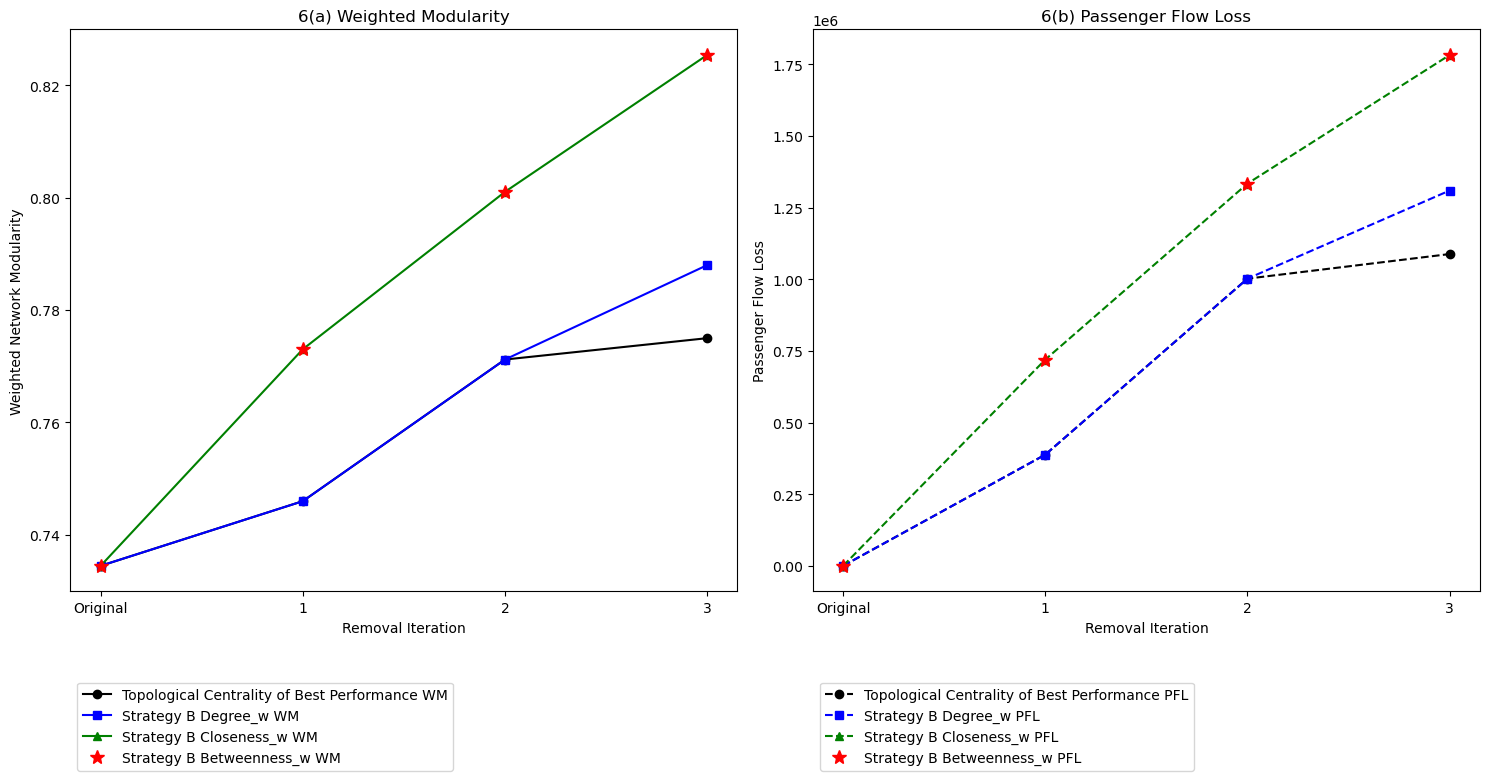

In [98]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# 子图1 - 加权网络模块化
axs[0].plot(iterations, modularity_betweenness, 'k-o', label='Topological Centrality of Best Performance WM')
axs[0].plot(iterations, modularity_degree_w, 'b-s', label='Strategy B Degree_w WM')
axs[0].plot(iterations, modularity_closeness_w, 'g-^', label='Strategy B Closeness_w WM')
axs[0].plot(iterations, modularity_betweenness_w, 'r*', label='Strategy B Betweenness_w WM', markersize=10)
axs[0].set_title('6(a) Weighted Modularity')
axs[0].set_xlabel('Removal Iteration')
axs[0].set_ylabel('Weighted Network Modularity')
axs[0].legend(loc='lower left')

# 子图2 - 客流损失
axs[1].plot(iterations, passenger_loss_betweenness, 'k--o', label='Topological Centrality of Best Performance PFL')
axs[1].plot(iterations, passenger_loss_degree_w, 'b--s', label='Strategy B Degree_w PFL')
axs[1].plot(iterations, passenger_loss_closeness_w, 'g--^', label='Strategy B Closeness_w PFL')
axs[1].plot(iterations, passenger_loss_betweenness_w, 'r*', label='Strategy B Betweenness_w PFL', linestyle='None', markersize=10) 
axs[1].set_title('6(b) Passenger Flow Loss')
axs[1].set_xlabel('Removal Iteration')
axs[1].set_ylabel('Passenger Flow Loss')
axs[1].legend(loc='upper left')

axs[0].legend(loc='upper left', bbox_to_anchor=(0, -0.15))
axs[1].legend(loc='upper left', bbox_to_anchor=(0, -0.15))

plt.tight_layout()
plt.savefig("outputs/WM_vs_PFL.png", format='png', dpi=300, bbox_inches='tight')
plt.show()